In [1]:
import os
import pandas as pd
import numpy as np
import re
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from difflib import SequenceMatcher
from collections import Counter
from nltk.corpus import stopwords

In [326]:
def pipeline(df, split_cols, remove_char_cols, col, time_col, merge_col, replace_col, map_month_dict, criterion_merge, criterion_replace, stop_words, source_name):
    
    split_text(df=df,
               cols=split_cols)
    
    remove_character(df=df,
                     cols=remove_char_cols)
    
    drop_useless_row (df=df,
                      col=col)
    
    alignment_time(df=df,
                   time_col=time_col,
                   map_month_dict=map_month_dict)
    
    df=merge_row_similarity(df=df,
                            col=merge_col,
                            criterion=criterion_merge)
    
    replace_similar_values(df=df,
                       col=replace_col,
                       criterion=criterion_replace)
    
    df_word=word_dict(df=df,
                   col=col,
                   stop_words=stop_words)
    
    df_word2=merge_word(df=df_word,
                       source_name=source_name)

    return df, df_word2

In [2]:
# return a dictionary containing all df in values
def get_df():
    cwd=os.getcwd()  # get current path
    df_dict={}
    for csv_name in [i for i in os.listdir(cwd) if i.endswith('.csv')]:
        df_name=csv_name.split('.')[1]
        df_path=os.path.join(cwd, csv_name)
        df_dict[df_name]=pd.read_csv(df_path)
    return df_dict

In [3]:
# Text treatment

def alignment_text(x):
    x=unicodedata.normalize('NFD', x)
    return (
        (x.encode('ascii', errors='ignore')
         .decode('utf-8')
        ).upper()
    ).rstrip()

def split_text(df, cols):
    for col in cols:
        df[col]=df[col].apply(lambda x: str(x))
        df[col]=df[col].apply(alignment_text)
        df[col]=df[col].apply(lambda x: x.split(' '))

def remove_character(df, cols):
    for col in cols:
        df[col]=df[col].apply(lambda x: [str(i) for i in x])
        df[col]=df[col].apply(lambda x: [("").join(re.findall('[\w+]',i)) for i in x])
        df[col]=df[col].apply(lambda x: (" ").join(x))

def drop_useless_row (df, col):
    index_drop=df[df[col].isin([np.NaN, '', None, ' ', ['']])].index
    df.drop(index=index_drop.values, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [4]:
# Time treatment

# turn month from text to numerical format
# example: 1 January 2020 => 1 JANUARY 2020 => 1 01 2020
def alignment_month(x, map_dict):
    month_str=('').join(re.findall('[A-Za-z]', x))
    if len(month_str) >  0:
        month_num=pd.Series([month_str.upper()]).map(map_dict).values[0]
        x=re.sub(month_str, month_num, x)
    return x

def get_ymd(x):
    time_set=re.findall('\s*(\d+)\s*', x)                                           # output=['2020', '01', '01']
    time_set_len=[len(i) for i in time_set]                                         # output=[4, 2, 2]                                    
    time_set_loc=dict((length, index) for index,length in enumerate(time_set_len))  # output={4:0, 2:2}
    
    # get year
    year=time_set[time_set_loc[4]]
    
    # get month
    month=time_set[1]
    if len(month)==1:
        month='0'+month
    
    # get day
    day=time_set[2-time_set_loc[4]]
    if len(day)==1:
        day='0'+day
    
    x=('/').join([day, month, year])
    return x

def alignment_time(df, time_col, map_month_dict):
    df[time_col]=df[time_col].apply(lambda x: alignment_month(x, map_month_dict))
    df[time_col]=df[time_col].apply(lambda x: get_ymd(x))

In [115]:
def merge_row_similarity(df, col, criterion):
    doc=list(df[col].values)   # ['XXXX', 'XXXX', 'XXX',...]

    # identify the rows who have similar content by TfidfVectorizer
    vect = TfidfVectorizer(min_df=1, stop_words="english")
    tfidf = vect.fit_transform(doc)
    pairwise_similarity = tfidf * tfidf.T
    
    df_similarity=pd.DataFrame(pairwise_similarity.toarray())
    df_similarity['count']=(df_similarity>criterion).replace(False, np.NaN).count(axis=1)
    df_similarity['s_index']=df_similarity.apply((lambda x: sorted([count for count, value in enumerate(x) if value >criterion and value <1.0001 and x['count']>1])),axis=1)
    df_similarity['s_index']=df_similarity['s_index'].astype(str) # trun [4,5] into string for groupby function
    index_group=[] # save all similar rows' index
    
    for i in df_similarity.groupby('s_index'):
        index_id=re.findall('.(\d+).',i[0])      # output: ['4', '5']
        index_id=list(map(int, index_id))        # output: [4, 5]
        if len(index_id)>0:
            index_group.append(index_id)         # output: [[4,5], [x,y,z],...]
    
    # replace the multiple rows by only one new merged row
    if len(index_group)>0:
        df_new=pd.DataFrame(columns=df.columns)
        for index_s in index_group:
            df_new_s=pd.DataFrame(columns=df.columns)
            df_old_s=df[df.index.isin(index_s)]
            for i in df_old_s.columns.values:
                values=list(df_old_s[i].values)
                values=sum([], values)
                values=list(filter(lambda x: x not in [np.NaN, None, '', ' ', 'NAN', 'None', 'nan'], values)) # remove useless information
                values=list(set(values))
                if len(values)==1:
                    df_new_s[i]=values
                else:
                    df_new_s[i]=[values]
            df_new=pd.concat([df_new_s,df_new], axis=0, ignore_index=True, copy=False)
        df.drop(index=sum(index_group,[]), inplace=True)
        df=pd.concat([df,df_new], axis=0, ignore_index=True)
    return df

In [6]:
# for some columns who have categorical values, we need to replace similar values by the majeur one
# example: ['Apple', 'Apple', 'Apple', 'Aapple', 'Apples'] => ['Apple'] x5

def replace_similar_values(df, col, criterion):
    
    # count element in the column
    count=Counter(list(df[col].values))
    count=dict(count)                                              
    count=pd.DataFrame([list(count.keys()), list(count.values())]).T
    count.columns=['name', 'count']
    count.sort_values(by='count', inplace=True, ascending=False)
    
    # we compare the similarity with unique values
    unique_items=list(set(df[col].values))
    df_sim=pd.DataFrame(index=unique_items, columns=unique_items)

    for i in unique_items:
        for j in unique_items:
            df_sim.loc[i,j]= SequenceMatcher(None, i, j).ratio()
            
    df_sim['count']=(df_sim>criterion).replace(False, np.NaN).count(axis=1)
    df_sim['s_index']=df_sim.apply((lambda x: sorted([count for count, value in enumerate(x) if value >criterion and value <1.0001 and x['count']>1])),axis=1)
    
    # replace the values in the original df
    df_sim['s_index']=df_sim['s_index'].astype(str)
    for i in df_sim.groupby('s_index'):
        index_id=re.findall('.(\d+).',i[0])
        index_id=list(map(int, index_id))
        if len(index_id)>0:
            index_id=df_sim.iloc[index_id].index.values
            top_name=count[count.name.isin(index_id)]['name'][0]
            df[col].replace(index_id, top_name, inplace=True)
    return df

In [329]:
def word_dict (df, col, stop_words):
    
    # turn "hello world" into ['hello', 'word']
    df['word_split']=df[col].apply(lambda x: x.split(' '))
    
    # remove stop words from string for each row
    df['word_split']=df['word_split'].apply(lambda x: list(set(x).difference(set(stop_words))))
    
    # remove digital word like '2' from string
    df['word_split']=df['word_split'].apply(lambda x: [i for i in x if not i.isdigit()])
    
    # join word, date, journal
    df['combinaison']=df.apply(lambda x: [[i, x['date'], x['journal'], x['id']] for i in x['word_split']], axis=1)
    
    df_word=pd.DataFrame(sum(df['combinaison'].values.tolist(),[]))
    df_word.columns=['word', 'date', 'journal', 'reference']
    df_word=df_word.drop_duplicates(ignore_index=True)
    
    df.drop(columns=['word_split', 'combinaison'], inplace=True)
    return df_word

In [289]:
# if one word has been quoted several times for several journals
def merge_word (df, source_name):
    
    df_new=pd.DataFrame(columns=df.columns) # new df to save the merged row
    index_drop=[]                           # row to be dropped in df
    
    for i in df.groupby('word'):
        if len(i[1])>1:
            
            print(i[1])
            print('************')
           
            new_row=pd.DataFrame(columns=i[1].columns)       
            new_row['word']=[i[0]]
            new_row['date']=[list(i[1].date.values)]
            new_row['journal']=[list(i[1].journal.values)]
            new_row['reference']=[list(i[1].reference.values)]
            
            df_new=pd.concat([df_new, new_row], ignore_index=True)
            index_drop.append(list(i[1].index.values))
            
    index_drop=sum(index_drop,[])        
    df.drop(index=index_drop, inplace=True)
    df=pd.concat([df,df_new],axis=0, ignore_index=True)
    df['source']=source_name
    return df

In [ ]:
map_month_dict=dict(zip(['JANUARY', 'FEBRUARY', 'MARTCH', 'APRIL'], ['01', '02', '03', '04']))
stop_words = [i.upper() for i in set(stopwords.words('english'))]

In [245]:
df_set=get_df()

## clinical trial

In [290]:
df_clinical=df_set['clinical_trials'].copy()
df_clinical

,id,scientific_title,date,journal
0,NCT01967433,Use of Diphenhydramine as an Adjunctive Sedati...,1 January 2020,Journal of emergency nursing
1,NCT04189588,Phase 2 Study IV QUZYTTIR™ (Cetirizine Hydroch...,1 January 2020,Journal of emergency nursing
2,NCT04237090,,1 January 2020,Journal of emergency nursing
3,NCT04237091,Feasibility of a Randomized Controlled Clinica...,1 January 2020,Journal of emergency nursing
4,NCT04153396,Preemptive Infiltration With Betamethasone and...,1 January 2020,Hôpitaux Universitaires de Genève
5,NCT03490942,Glucagon Infusion in T1D Patients With Recurre...,25/05/2020,NaN
6,NaN,Glucagon Infusion in T1D Patients With Recurre...,25/05/2020,Journal of emergency nursing
7,NCT04188184,Tranexamic Acid Versus Epinephrine During Expl...,27 April 2020,Journal of emergency nursing\xc3\x28


In [291]:
split_text(df=df_clinical, cols=['scientific_title', 'journal', 'id'])
df_clinical

,id,scientific_title,date,journal
0,[NCT01967433],"[USE, OF, DIPHENHYDRAMINE, AS, AN, ADJUNCTIVE,...",1 January 2020,"[JOURNAL, OF, EMERGENCY, NURSING]"
1,[NCT04189588],"[PHASE, 2, STUDY, IV, QUZYTTIR, (CETIRIZINE, H...",1 January 2020,"[JOURNAL, OF, EMERGENCY, NURSING]"
2,[NCT04237090],[],1 January 2020,"[JOURNAL, OF, EMERGENCY, NURSING]"
3,[NCT04237091],"[FEASIBILITY, OF, A, RANDOMIZED, CONTROLLED, C...",1 January 2020,"[JOURNAL, OF, EMERGENCY, NURSING]"
4,[NCT04153396],"[PREEMPTIVE, INFILTRATION, WITH, BETAMETHASONE...",1 January 2020,"[HOPITAUX, UNIVERSITAIRES, DE, GENEVE]"
5,[NCT03490942],"[GLUCAGON, INFUSION, IN, T1D, PATIENTS, WITH, ...",25/05/2020,[NAN]
6,[NAN],"[GLUCAGON, INFUSION, IN, T1D, PATIENTS, WITH, ...",25/05/2020,"[JOURNAL, OF, EMERGENCY, NURSING]"
7,[NCT04188184],"[TRANEXAMIC, ACID, VERSUS, EPINEPHRINE, DURING...",27 April 2020,"[JOURNAL, OF, EMERGENCY, NURSING\XC3\X28]"


In [292]:
remove_character(df=df_clinical, cols=['scientific_title', 'journal', 'id'])
df_clinical

,id,scientific_title,date,journal
0,NCT01967433,USE OF DIPHENHYDRAMINE AS AN ADJUNCTIVE SEDATI...,1 January 2020,JOURNAL OF EMERGENCY NURSING
1,NCT04189588,PHASE 2 STUDY IV QUZYTTIR CETIRIZINE HYDROCHLO...,1 January 2020,JOURNAL OF EMERGENCY NURSING
2,NCT04237090,,1 January 2020,JOURNAL OF EMERGENCY NURSING
3,NCT04237091,FEASIBILITY OF A RANDOMIZED CONTROLLED CLINICA...,1 January 2020,JOURNAL OF EMERGENCY NURSING
4,NCT04153396,PREEMPTIVE INFILTRATION WITH BETAMETHASONE AND...,1 January 2020,HOPITAUX UNIVERSITAIRES DE GENEVE
5,NCT03490942,GLUCAGON INFUSION IN T1D PATIENTS WITH RECURRE...,25/05/2020,NAN
6,NAN,GLUCAGON INFUSION IN T1D PATIENTS WITH RECURRE...,25/05/2020,JOURNAL OF EMERGENCY NURSING
7,NCT04188184,TRANEXAMIC ACID VERSUS EPINEPHRINE DURING EXPL...,27 April 2020,JOURNAL OF EMERGENCY NURSINGXC3X28


In [293]:
drop_useless_row (df=df_clinical, col='scientific_title')
df_clinical

,id,scientific_title,date,journal
0,NCT01967433,USE OF DIPHENHYDRAMINE AS AN ADJUNCTIVE SEDATI...,1 January 2020,JOURNAL OF EMERGENCY NURSING
1,NCT04189588,PHASE 2 STUDY IV QUZYTTIR CETIRIZINE HYDROCHLO...,1 January 2020,JOURNAL OF EMERGENCY NURSING
2,NCT04237091,FEASIBILITY OF A RANDOMIZED CONTROLLED CLINICA...,1 January 2020,JOURNAL OF EMERGENCY NURSING
3,NCT04153396,PREEMPTIVE INFILTRATION WITH BETAMETHASONE AND...,1 January 2020,HOPITAUX UNIVERSITAIRES DE GENEVE
4,NCT03490942,GLUCAGON INFUSION IN T1D PATIENTS WITH RECURRE...,25/05/2020,NAN
5,NAN,GLUCAGON INFUSION IN T1D PATIENTS WITH RECURRE...,25/05/2020,JOURNAL OF EMERGENCY NURSING
6,NCT04188184,TRANEXAMIC ACID VERSUS EPINEPHRINE DURING EXPL...,27 April 2020,JOURNAL OF EMERGENCY NURSINGXC3X28


In [294]:
alignment_time(df=df_clinical,
               time_col='date',
               map_month_dict=map_month_dict)
df_clinical

,id,scientific_title,date,journal
0,NCT01967433,USE OF DIPHENHYDRAMINE AS AN ADJUNCTIVE SEDATI...,01/01/2020,JOURNAL OF EMERGENCY NURSING
1,NCT04189588,PHASE 2 STUDY IV QUZYTTIR CETIRIZINE HYDROCHLO...,01/01/2020,JOURNAL OF EMERGENCY NURSING
2,NCT04237091,FEASIBILITY OF A RANDOMIZED CONTROLLED CLINICA...,01/01/2020,JOURNAL OF EMERGENCY NURSING
3,NCT04153396,PREEMPTIVE INFILTRATION WITH BETAMETHASONE AND...,01/01/2020,HOPITAUX UNIVERSITAIRES DE GENEVE
4,NCT03490942,GLUCAGON INFUSION IN T1D PATIENTS WITH RECURRE...,25/05/2020,NAN
5,NAN,GLUCAGON INFUSION IN T1D PATIENTS WITH RECURRE...,25/05/2020,JOURNAL OF EMERGENCY NURSING
6,NCT04188184,TRANEXAMIC ACID VERSUS EPINEPHRINE DURING EXPL...,27/04/2020,JOURNAL OF EMERGENCY NURSINGXC3X28


In [295]:
df_clinical=merge_row_similarity(df=df_clinical,
                     col='scientific_title',
                     criterion=0.9)
df_clinical

,id,scientific_title,date,journal
0,NCT01967433,USE OF DIPHENHYDRAMINE AS AN ADJUNCTIVE SEDATI...,01/01/2020,JOURNAL OF EMERGENCY NURSING
1,NCT04189588,PHASE 2 STUDY IV QUZYTTIR CETIRIZINE HYDROCHLO...,01/01/2020,JOURNAL OF EMERGENCY NURSING
2,NCT04237091,FEASIBILITY OF A RANDOMIZED CONTROLLED CLINICA...,01/01/2020,JOURNAL OF EMERGENCY NURSING
3,NCT04153396,PREEMPTIVE INFILTRATION WITH BETAMETHASONE AND...,01/01/2020,HOPITAUX UNIVERSITAIRES DE GENEVE
4,NCT04188184,TRANEXAMIC ACID VERSUS EPINEPHRINE DURING EXPL...,27/04/2020,JOURNAL OF EMERGENCY NURSINGXC3X28
5,NCT03490942,GLUCAGON INFUSION IN T1D PATIENTS WITH RECURRE...,25/05/2020,JOURNAL OF EMERGENCY NURSING


In [296]:
replace_similar_values(df=df_clinical,
                       col='journal',
                       criterion=0.9)
df_clinical

,id,scientific_title,date,journal
0,NCT01967433,USE OF DIPHENHYDRAMINE AS AN ADJUNCTIVE SEDATI...,01/01/2020,JOURNAL OF EMERGENCY NURSING
1,NCT04189588,PHASE 2 STUDY IV QUZYTTIR CETIRIZINE HYDROCHLO...,01/01/2020,JOURNAL OF EMERGENCY NURSING
2,NCT04237091,FEASIBILITY OF A RANDOMIZED CONTROLLED CLINICA...,01/01/2020,JOURNAL OF EMERGENCY NURSING
3,NCT04153396,PREEMPTIVE INFILTRATION WITH BETAMETHASONE AND...,01/01/2020,HOPITAUX UNIVERSITAIRES DE GENEVE
4,NCT04188184,TRANEXAMIC ACID VERSUS EPINEPHRINE DURING EXPL...,27/04/2020,JOURNAL OF EMERGENCY NURSING
5,NCT03490942,GLUCAGON INFUSION IN T1D PATIENTS WITH RECURRE...,25/05/2020,JOURNAL OF EMERGENCY NURSING


In [297]:
df_word_cli=word_dict (df=df_clinical,
                   col='scientific_title',
                   stop_words=stop_words)
df_word_cli

,word,date,journal,reference
0,OPIOIDS,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433
1,SEDATIVE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433
2,USE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433
3,CHRONICALLY,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433
4,ADJUNCTIVE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433
5,PATIENTS,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433
6,COLONOSCOPY,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433
7,DIPHENHYDRAMINE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433
8,QUZYTTIR,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588
9,CETIRIZINE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588


In [298]:
df_word_cli_2=merge_word(df_word_cli,
                     source_name='clinical')
df_word_cli_2

          word        date                       journal    reference
9   CETIRIZINE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT04189588
20  CETIRIZINE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT04237091
************
               word        date                       journal    reference
7   DIPHENHYDRAMINE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT01967433
16  DIPHENHYDRAMINE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT04189588
28  DIPHENHYDRAMINE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT04237091
************
        word        date                       journal    reference
5   PATIENTS  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT01967433
52  PATIENTS  25/05/2020  JOURNAL OF EMERGENCY NURSING  NCT03490942
************
   word        date                       journal    reference
2   USE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT01967433
19  USE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT04237091
************


,word,date,journal,reference,source
0,OPIOIDS,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433,clinical
1,SEDATIVE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433,clinical
2,CHRONICALLY,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433,clinical
3,ADJUNCTIVE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433,clinical
4,COLONOSCOPY,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433,clinical
5,QUZYTTIR,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588,clinical
6,HYDROCHLORIDE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588,clinical
7,VS,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588,clinical
8,INJECTION,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588,clinical
9,STUDY,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588,clinical


### or directly by the pipeline function

In [323]:
df_set['clinical_trials']

,id,scientific_title,date,journal
0,NCT01967433,Use of Diphenhydramine as an Adjunctive Sedati...,1 January 2020,Journal of emergency nursing
1,NCT04189588,Phase 2 Study IV QUZYTTIR™ (Cetirizine Hydroch...,1 January 2020,Journal of emergency nursing
2,NCT04237090,,1 January 2020,Journal of emergency nursing
3,NCT04237091,Feasibility of a Randomized Controlled Clinica...,1 January 2020,Journal of emergency nursing
4,NCT04153396,Preemptive Infiltration With Betamethasone and...,1 January 2020,Hôpitaux Universitaires de Genève
5,NCT03490942,Glucagon Infusion in T1D Patients With Recurre...,25/05/2020,NaN
6,NaN,Glucagon Infusion in T1D Patients With Recurre...,25/05/2020,Journal of emergency nursing
7,NCT04188184,Tranexamic Acid Versus Epinephrine During Expl...,27 April 2020,Journal of emergency nursing\xc3\x28


In [330]:
df_clinical=df_set['clinical_trials'].copy()
df_clinical, df_clinical_word=pipeline(df=df_clinical,
                                       split_cols=['scientific_title', 'journal', 'id'],
                                       remove_char_cols=['scientific_title', 'journal', 'id'],
                                       col='scientific_title',
                                       time_col='date',
                                       merge_col='scientific_title',
                                       replace_col='journal',
                                       map_month_dict=map_month_dict,
                                       criterion_merge=0.9,
                                       criterion_replace=0.9,
                                       stop_words=stop_words,
                                       source_name='clinical')

          word        date                       journal    reference
9   CETIRIZINE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT04189588
20  CETIRIZINE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT04237091
************
               word        date                       journal    reference
7   DIPHENHYDRAMINE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT01967433
16  DIPHENHYDRAMINE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT04189588
28  DIPHENHYDRAMINE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT04237091
************
        word        date                       journal    reference
5   PATIENTS  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT01967433
52  PATIENTS  25/05/2020  JOURNAL OF EMERGENCY NURSING  NCT03490942
************
   word        date                       journal    reference
2   USE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT01967433
19  USE  01/01/2020  JOURNAL OF EMERGENCY NURSING  NCT04237091
************


In [331]:
df_clinical

,id,scientific_title,date,journal
0,NCT01967433,USE OF DIPHENHYDRAMINE AS AN ADJUNCTIVE SEDATI...,01/01/2020,JOURNAL OF EMERGENCY NURSING
1,NCT04189588,PHASE 2 STUDY IV QUZYTTIR CETIRIZINE HYDROCHLO...,01/01/2020,JOURNAL OF EMERGENCY NURSING
2,NCT04237091,FEASIBILITY OF A RANDOMIZED CONTROLLED CLINICA...,01/01/2020,JOURNAL OF EMERGENCY NURSING
3,NCT04153396,PREEMPTIVE INFILTRATION WITH BETAMETHASONE AND...,01/01/2020,HOPITAUX UNIVERSITAIRES DE GENEVE
4,NCT04188184,TRANEXAMIC ACID VERSUS EPINEPHRINE DURING EXPL...,27/04/2020,JOURNAL OF EMERGENCY NURSING
5,NCT03490942,GLUCAGON INFUSION IN T1D PATIENTS WITH RECURRE...,25/05/2020,JOURNAL OF EMERGENCY NURSING


In [332]:
df_clinical_word

,word,date,journal,reference,source
0,OPIOIDS,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433,clinical
1,SEDATIVE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433,clinical
2,CHRONICALLY,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433,clinical
3,ADJUNCTIVE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433,clinical
4,COLONOSCOPY,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT01967433,clinical
5,QUZYTTIR,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588,clinical
6,HYDROCHLORIDE,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588,clinical
7,VS,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588,clinical
8,INJECTION,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588,clinical
9,STUDY,01/01/2020,JOURNAL OF EMERGENCY NURSING,NCT04189588,clinical


## Pubmed

In [334]:
df_pubmed=df_set['pubmed'].copy()
df_pubmed

,id,title,date,journal
0,1,A 44-year-old man with erythema of the face di...,01/01/2019,Journal of emergency nursing
1,2,"An evaluation of benadryl, pyribenzamine, and ...",01/01/2019,Journal of emergency nursing
2,3,Diphenhydramine hydrochloride helps symptoms o...,02/01/2019,The Journal of pediatrics
3,4,Tetracycline Resistance Patterns of Lactobacil...,01/01/2020,Journal of food protection
4,5,Appositional Tetracycline bone formation rates...,02/01/2020,American journal of veterinary research
5,6,Rapid reacquisition of contextual fear followi...,2020-01-01,Psychopharmacology
6,7,The High Cost of Epinephrine Autoinjectors and...,01/02/2020,The journal of allergy and clinical immunology...
7,8,Time to epinephrine treatment is associated wi...,01/03/2020,The journal of allergy and clinical immunology...


In [335]:
df_pubmed, df_pubmed_word=pipeline(df=df_pubmed,
                                   split_cols=['title', 'journal', 'id'],
                                   remove_char_cols=['title', 'journal', 'id'],
                                   col='title',
                                   time_col='date',
                                   merge_col='title',
                                   replace_col='journal',
                                   map_month_dict=map_month_dict,
                                   criterion_merge=0.9,
                                   criterion_replace=0.9,
                                   stop_words=stop_words,
                                   source_name='pubmed')

               word        date                       journal reference
8   DIPHENHYDRAMINE  01/01/2019  JOURNAL OF EMERGENCY NURSING         1
15  DIPHENHYDRAMINE  01/01/2019  JOURNAL OF EMERGENCY NURSING         2
23  DIPHENHYDRAMINE  02/01/2019     THE JOURNAL OF PEDIATRICS         3
************
           word        date  \
54  EPINEPHRINE  01/02/2020   
59  EPINEPHRINE  01/03/2020   

                                              journal reference  
54  THE JOURNAL OF ALLERGY AND CLINICAL IMMUNOLOGY...         7  
59  THE JOURNAL OF ALLERGY AND CLINICAL IMMUNOLOGY...         8  
************
            word        date                                  journal  \
29  TETRACYCLINE  01/01/2020               JOURNAL OF FOOD PROTECTION   
33  TETRACYCLINE  02/01/2020  AMERICAN JOURNAL OF VETERINARY RESEARCH   
46  TETRACYCLINE  01/01/2020                       PSYCHOPHARMACOLOGY   

   reference  
29         4  
33         5  
46         6  
************
         word        date   

In [336]:
df_pubmed

,id,title,date,journal
0,1,A 44YEAROLD MAN WITH ERYTHEMA OF THE FACE DIPH...,01/01/2019,JOURNAL OF EMERGENCY NURSING
1,2,AN EVALUATION OF BENADRYL PYRIBENZAMINE AND OT...,01/01/2019,JOURNAL OF EMERGENCY NURSING
2,3,DIPHENHYDRAMINE HYDROCHLORIDE HELPS SYMPTOMS O...,02/01/2019,THE JOURNAL OF PEDIATRICS
3,4,TETRACYCLINE RESISTANCE PATTERNS OF LACTOBACIL...,01/01/2020,JOURNAL OF FOOD PROTECTION
4,5,APPOSITIONAL TETRACYCLINE BONE FORMATION RATES...,02/01/2020,AMERICAN JOURNAL OF VETERINARY RESEARCH
5,6,RAPID REACQUISITION OF CONTEXTUAL FEAR FOLLOWI...,01/01/2020,PSYCHOPHARMACOLOGY
6,7,THE HIGH COST OF EPINEPHRINE AUTOINJECTORS AND...,01/02/2020,THE JOURNAL OF ALLERGY AND CLINICAL IMMUNOLOGY...
7,8,TIME TO EPINEPHRINE TREATMENT IS ASSOCIATED WI...,01/03/2020,THE JOURNAL OF ALLERGY AND CLINICAL IMMUNOLOGY...


In [337]:
df_pubmed_word

,word,date,journal,reference,source
0,NECK,01/01/2019,JOURNAL OF EMERGENCY NURSING,1,pubmed
1,ERYTHEMA,01/01/2019,JOURNAL OF EMERGENCY NURSING,1,pubmed
2,44YEAROLD,01/01/2019,JOURNAL OF EMERGENCY NURSING,1,pubmed
3,PALPITATIONS,01/01/2019,JOURNAL OF EMERGENCY NURSING,1,pubmed
4,FACE,01/01/2019,JOURNAL OF EMERGENCY NURSING,1,pubmed
...,...,...,...,...,...
61,TRAUMATIC,01/03/2020,THE JOURNAL OF ALLERGY AND CLINICAL IMMUNOLOGY...,8,pubmed
62,DIPHENHYDRAMINE,"[01/01/2019, 01/01/2019, 02/01/2019]","[JOURNAL OF EMERGENCY NURSING, JOURNAL OF EMER...","[1, 2, 3]",pubmed
63,EPINEPHRINE,"[01/02/2020, 01/03/2020]",[THE JOURNAL OF ALLERGY AND CLINICAL IMMUNOLOG...,"[7, 8]",pubmed
64,TETRACYCLINE,"[01/01/2020, 02/01/2020, 01/01/2020]","[JOURNAL OF FOOD PROTECTION, AMERICAN JOURNAL ...","[4, 5, 6]",pubmed


## Drugs

In [314]:
df_drugs=df_set['drugs'].copy()
drugs=df_drugs.drug.values

In [349]:
drugs

array(['DIPHENHYDRAMINE', 'TETRACYCLINE', 'ETHANOL', 'ATROPINE',
       'EPINEPHRINE', 'ISOPRENALINE', 'BETAMETHASONE'], dtype=object)

In [338]:
df_clinical_word[df_clinical_word.word.isin(drugs)]

,word,date,journal,reference,source
30,BETAMETHASONE,01/01/2020,HOPITAUX UNIVERSITAIRES DE GENEVE,NCT04153396,clinical
34,EPINEPHRINE,27/04/2020,JOURNAL OF EMERGENCY NURSING,NCT04188184,clinical
49,DIPHENHYDRAMINE,"[01/01/2020, 01/01/2020, 01/01/2020]","[JOURNAL OF EMERGENCY NURSING, JOURNAL OF EMER...","[NCT01967433, NCT04189588, NCT04237091]",clinical


In [339]:
df_pubmed_word[df_pubmed_word.word.isin(drugs)]

,word,date,journal,reference,source
32,ETHANOL,01/01/2020,PSYCHOPHARMACOLOGY,6,pubmed
62,DIPHENHYDRAMINE,"[01/01/2019, 01/01/2019, 02/01/2019]","[JOURNAL OF EMERGENCY NURSING, JOURNAL OF EMER...","[1, 2, 3]",pubmed
63,EPINEPHRINE,"[01/02/2020, 01/03/2020]",[THE JOURNAL OF ALLERGY AND CLINICAL IMMUNOLOG...,"[7, 8]",pubmed
64,TETRACYCLINE,"[01/01/2020, 02/01/2020, 01/01/2020]","[JOURNAL OF FOOD PROTECTION, AMERICAN JOURNAL ...","[4, 5, 6]",pubmed


## Run Pipeline.py

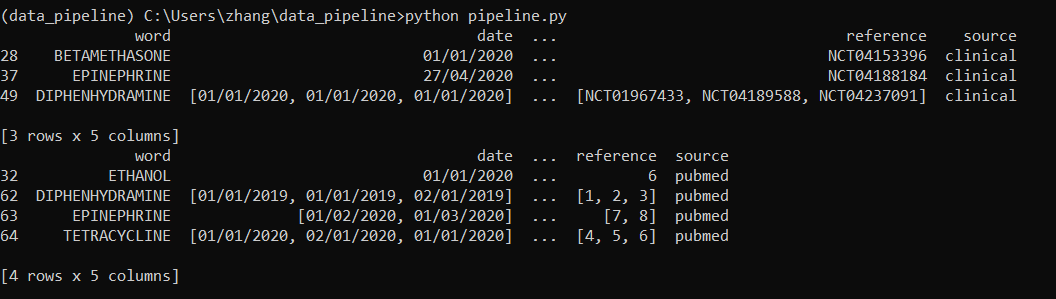

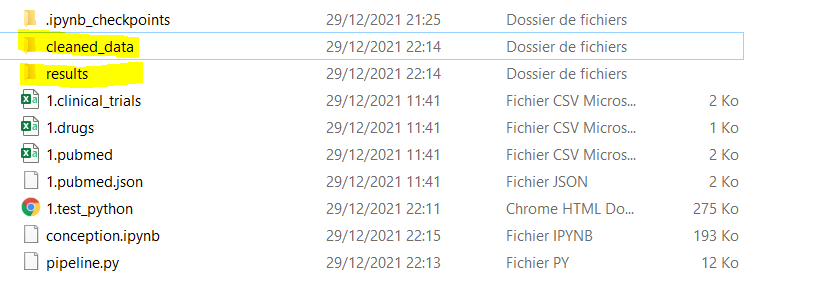

In [341]:
clinical=pd.read_csv('cleaned_data/clinical.csv')
clinical

,Unnamed: 0,id,scientific_title,date,journal
0,0,NCT01967433,USE OF DIPHENHYDRAMINE AS AN ADJUNCTIVE SEDATI...,01/01/2020,JOURNAL OF EMERGENCY NURSING
1,1,NCT04189588,PHASE 2 STUDY IV QUZYTTIR CETIRIZINE HYDROCHLO...,01/01/2020,JOURNAL OF EMERGENCY NURSING
2,2,NCT04237091,FEASIBILITY OF A RANDOMIZED CONTROLLED CLINICA...,01/01/2020,JOURNAL OF EMERGENCY NURSING
3,3,NCT04153396,PREEMPTIVE INFILTRATION WITH BETAMETHASONE AND...,01/01/2020,HOPITAUX UNIVERSITAIRES DE GENEVE
4,4,NCT04188184,TRANEXAMIC ACID VERSUS EPINEPHRINE DURING EXPL...,27/04/2020,JOURNAL OF EMERGENCY NURSING
5,5,NCT03490942,GLUCAGON INFUSION IN T1D PATIENTS WITH RECURRE...,25/05/2020,JOURNAL OF EMERGENCY NURSING


In [343]:
re_clinical=pd.read_csv('results/search_drugs_inclinical.csv')
re_clinical

,Unnamed: 0,word,date,journal,reference,source
0,28,BETAMETHASONE,01/01/2020,HOPITAUX UNIVERSITAIRES DE GENEVE,NCT04153396,clinical
1,37,EPINEPHRINE,27/04/2020,JOURNAL OF EMERGENCY NURSING,NCT04188184,clinical
2,49,DIPHENHYDRAMINE,"['01/01/2020', '01/01/2020', '01/01/2020']","['JOURNAL OF EMERGENCY NURSING', 'JOURNAL OF E...","['NCT01967433', 'NCT04189588', 'NCT04237091']",clinical
